In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('parkinson_disease.csv')
pd.set_option('display.max_columns',10)
df.sample(5)

,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
605,201,0,0.81567,0.69416,0.70689,...,3.2464,2.6954,2.8035,4.3488,1
102,34,0,0.80056,0.73215,0.48029,...,4.5010,10.0738,13.0857,3.8367,0
39,13,1,0.80169,0.72330,0.32538,...,33.0818,22.9303,10.9895,5.9725,1
651,217,1,0.80089,0.74234,0.42171,...,14.2345,15.4242,16.1508,22.2100,1
470,156,1,0.78174,0.65600,0.59176,...,2.8284,4.3397,4.7578,4.3066,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [5]:
df.describe()

,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756.000000,756.000000,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.000000
mean,125.500000,0.515873,0.746284,0.700414,0.489058,...,12.375335,14.799230,14.751559,31.481110,0.746032
std,72.793721,0.500079,0.169294,0.069718,0.137442,...,16.341665,15.722502,14.432979,34.230991,0.435568
min,0.000000,0.000000,0.041551,0.543500,0.154300,...,1.628700,1.861700,1.955900,2.364000,0.000000
25%,62.750000,0.000000,0.762833,0.647053,0.386537,...,3.114375,3.665925,3.741275,3.948750,0.000000
50%,125.500000,1.000000,0.809655,0.700525,0.484355,...,4.741450,6.725700,7.334250,10.637250,1.000000
75%,188.250000,1.000000,0.834315,0.754985,0.586515,...,12.201325,21.922050,22.495175,61.125325,1.000000
max,251.000000,1.000000,0.907660,0.852640,0.871230,...,73.532200,62.007300,57.544300,156.423700,1.000000


In [8]:
df.isnull().sum().sum()

np.int64(0)

In [10]:
df.groupby('id').mean().reset_index()
df.drop('id',axis=1,inplace=True)

In [11]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])
        if val > 0.7:
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)

    df = df[filtered_columns]
df.shape

(756, 313)

In [12]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(756, 31)

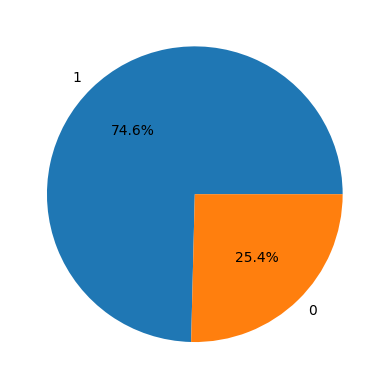

In [13]:
x=df['class'].value_counts()
plt.pie(x.values,labels=x.index,autopct='%1.1f%%')
plt.show()

In [14]:
features=df.drop('class',axis=1)
target=df['class']
X_train,X_test,Y_train,Y_test=train_test_split(features,target,test_size=0.2,random_state=10)
ros=RandomOverSampler(sampling_strategy=1.0,random_state=0)
X,Y=ros.fit_resample(X_train,Y_train)
X.shape,Y.value_counts()

((892, 30),
 class
 1    446
 0    446
 Name: count, dtype: int64)

In [19]:
from sklearn.metrics import roc_auc_score as ras

models = [LogisticRegression(class_weight='balanced'), XGBClassifier(), SVC(kernel='rbf', probability=True)]
for model in models:
    model.fit(X_train, Y_train)
    print(f'{model} : ')

    train_preds = model.predict(X_train)
    print('Training Accuracy : ', ras(Y_train, train_preds))

    val_preds = model.predict(X_test)
    print('Validation Accuracy : ', ras(Y_test, val_preds))
    print()

LogisticRegression(class_weight='balanced') : 
Training Accuracy :  0.75689674745984
Validation Accuracy :  0.7008973080757728

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.732801595214357

SVC(probability=True) : 
Training Accuracy :

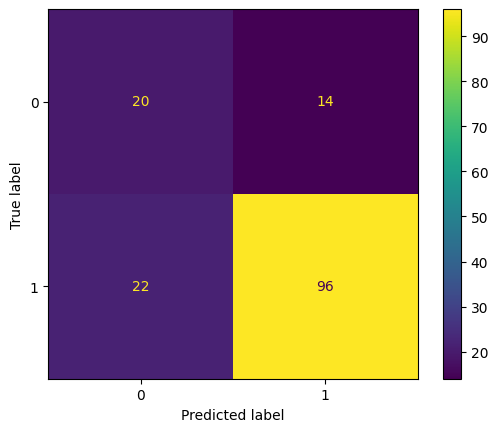

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(models[0],X_test,Y_test)
plt.show()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,models[0].predict(X_test)))

              precision    recall  f1-score   support

           0       0.48      0.59      0.53        34
           1       0.87      0.81      0.84       118

    accuracy                           0.76       152
   macro avg       0.67      0.70      0.68       152
weighted avg       0.78      0.76      0.77       152

